In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from algorithm.acorm import ACORM_Agent
from smac.env import StarCraft2Env
from types import SimpleNamespace
import json
import os

from PIL import Image
# Start Xvfb for rendering
os.system("Xvfb :99 -screen 0 1024x768x24 &")
os.environ["DISPLAY"] = ":99"

# Configure matplotlib for notebook

In [27]:
# Define arguments similar to your training script
args = SimpleNamespace(
    algorithm='ACORMWM',
    agent_net='Agent_Embedding',
    env_name='3s5z_vs_3s6z',  # Change this to match your scenario
    device='cuda:0' if torch.cuda.is_available() else 'cpu',
    seed=3,
    epsilon=0.0,  # No exploration during testing
    epsilon_min=0.0,
    use_hard_update=False,
    use_lr_decay=True,
    lr_decay_steps=500,
    lr_decay_rate=0.98,
    train_recl_freq=100,
    use_ln=True,
    role_tau=0.005,
    tau=0.005,
    cluster_num=4,
    agent_embedding_dim=128,
    rnn_hidden_dim=64,
    mlp_hidden_dim=64,
    hyper_hidden_dim=64,
    qmix_hidden_dim=32,
    hyper_layers_num=2,
    lr=6e-4,
    recl_lr=8e-4,
    role_embedding_dim=64,
    att_dim=128,
    att_out_dim=64,
    n_heads=4,
    soft_temperature=1.0,
    state_embed_dim=64,
    max_history=10,
    num_process_per_gpu=1,
    intrinsic_reward=True,
    gamma=0.99,
    batch_size=32,
    multi_steps=1,
    target_update_freq=200,
    add_last_action=True,
    max_train_steps=3000000,
    agent_embedding_lr=1e-4,
    model_path='./model/acormwm',
    save_path='./result/acormwm'
)
FOLDER="extended_results/{}/{}/".format(args.algorithm, args.env_name)
if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


In [28]:
def init_env_agent():
    # Initialize environment
    if 'protoss' in args.env_name or 'terran' in args.env_name or 'zerg' in args.env_name:
        from env.smacv2.smacv2_env import SMACv2Env
        print("Using SMACv2Env")
        env = SMACv2Env(args = {'map_name': args.env_name})
        env.seed(args.seed)
    else:
        from smac.env import StarCraft2Env
        env = StarCraft2Env(map_name=args.env_name, seed=args.seed)
    env_info = env.get_env_info()

    # Add environment info to args
    args.N = env_info["n_agents"]
    args.obs_dim = env_info["obs_shape"]
    args.state_dim = env_info["state_shape"]
    args.action_dim = env_info["n_actions"]
    
    # Initialize agent
    agent = ACORM_Agent(args)
    
    # Load trained model
    model_path = f'{args.model_path}/{args.env_name}_seed{args.seed}_'
    agent.eval_Q_net = torch.load(model_path + 'q_net.pth')
    agent.RECL.role_embedding_net = torch.load(model_path + 'role_net.pth')
    agent.RECL.agent_embedding_net = torch.load(model_path + 'agent_embed_net.pth')
    agent.eval_mix_net.attention_net = torch.load(model_path + 'attention_net.pth')
    agent.eval_mix_net = torch.load(model_path + 'mix_net.pth')
    
    return env, agent

In [29]:
def run_episode(env, agent, episode_num):
    episode_reward = 0
    step = 0
    done = False
    won = False
    
    # Reset environment
    env.reset()
    last_action = np.zeros((args.N, args.action_dim))
    role_embeddings = []
    frames = []
    states = []
    while not done:
        # Get observations
        obs = env.get_obs()
        state = env.get_state_dict()
        
        states.append(state['allies'])
        avail_actions = env.get_avail_actions()
        
        # Get role embeddings
        role_embedding = agent.get_role_embedding(obs, last_action)
        role_embeddings.append(role_embedding.detach().cpu().numpy())
    
        # Choose action
        actions = agent.choose_action(obs, last_action, role_embedding, avail_actions, args.epsilon)
        
        # Execute action
        reward, done, info = env.step(actions)
        won = info.get('battle_won', False)
        
        # Update last action
        last_action = np.eye(args.action_dim)[actions]
        
        episode_reward += reward
        step += 1
        
        frame = env.render(mode="rgb_array")
        if frame is not None:
            frames.append(Image.fromarray(frame))
    # env.save_replay()
    if frames:
        frames[0].save(
            FOLDER + "smac_replay_{}.gif".format(episode_num),
            save_all=True,
            append_images=frames[1:],
            duration=50,
            loop=0
        )
        print("GIF saved as smac_replay.gif")

    return episode_reward, step, won, role_embeddings, states

In [30]:
def test_policy(n_episodes=32):
    env, agent = init_env_agent()
    
    results = []
    for episode in range(n_episodes):
        reward, steps, won, role_embeddings, states = run_episode(env, agent, episode)
        results.append({
            'episode': episode,
            'reward': reward,
            'steps': steps,
            'won': won,
            'role_embeddings': role_embeddings,
            'states': extract_positions(env, [np.array(states)])
        })
        print(f"Episode {episode}: Reward = {reward:.2f}, Steps = {steps}, Won = {won}")
    
    env.close()
    return results

def extract_positions(env, states):
    
    # Extract positions of all agents from state
    positions = []

    for state in states:
        # State contains positions of all units (allies and enemies)
        # Each unit's position is represented by (x, y) coordinates
        # Extract positions from state array - first two elements per unit are x,y coords
        
        episode_positions = state[:, :,2:5]
        

        episode_positions[:, :, 0] = state[:, :, 2] 
        episode_positions[:, :, 1] = state[:, :, 3]
        episode_positions[:, :, 2] = state[:, :, 0]
        # episode_positions[state[:,:,0]==0] = positions[-1]
        positions.append(episode_positions)
    print(positions)
    return positions
    

In [31]:
results = test_policy()

------add last action------
hyper_layers_num=2
hyper_layers_num=2


Version: B75689 (SC2.4.10)
Build: Aug 12 2019 17:16:57
Command Line: '"/home/hg22723/StarCraftII/Versions/Base75689/SC2_x64" -listen 127.0.0.1 -port 42075 -dataDir /home/hg22723/StarCraftII/ -tempDir /tmp/sc-aje_85fe/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:42075
Startup Phase 3 complete. Ready for commands.
ConnectHandler: Request from 127.0.0.1:46304 accepted
ReadyHandler: 127.0.0.1:46304 ready
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8
Game has started.
Using default stable ids, none found at: /home/hg22723/StarCra

GIF saved as smac_replay.gif
[array([[[-0.25      , -0.04244559,  1.        ],
        [-0.25      ,  0.        ,  1.        ],
        [-0.20755441,  0.        ,  1.        ],
        ...,
        [-0.26785714,  0.03571429,  1.        ],
        [-0.25      ,  0.07142857,  1.        ],
        [-0.23214286,  0.03571429,  1.        ]],

       [[-0.29725865, -0.04898507,  1.        ],
        [-0.20229667, -0.00391497,  1.        ],
        [-0.20305525,  0.05088588,  1.        ],
        ...,
        [-0.30455671,  0.04210554,  1.        ],
        [-0.2893328 ,  0.07350377,  1.        ],
        [-0.27144078,  0.03694371,  1.        ]],

       [[-0.24762835, -0.05291748,  1.        ],
        [-0.20908029,  0.0146746 ,  1.        ],
        [-0.20305525,  0.10362026,  1.        ],
        ...,
        [-0.34473528,  0.04210554,  1.        ],
        [-0.32951137,  0.07350377,  1.        ],
        [-0.31161935,  0.03694371,  1.        ]],

       ...,

       [[-0.04471261, -0.11811

RequestQuit command received.
DataHandler: unable to parse websocket frame.
CloseHandler: 127.0.0.1:46304 disconnected
Closing Application...


In [32]:
# Run test episodes

positions = [r['states'] for r in results]
# Convert results to numpy arrays for analysis
rewards = np.array([r['reward'] for r in results])
steps = np.array([r['steps'] for r in results])
wins = np.array([r['won'] for r in results])
role_embeddings = [r['role_embeddings'] for r in results]

# Save the role embeddings to a file

# Convert role embeddings to numpy array and save
# Path 
if not os.path.exists(f'{args.save_path}/embeddings'):
    os.makedirs(f'{args.save_path}/embeddings')
embeddings_path = f'{args.save_path}/embeddings/{args.env_name}_seed{args.seed}_embeddings.npy'
np.save(embeddings_path, np.array(role_embeddings, dtype=object))

# Print summary statistics
print(f"Average reward: {rewards.mean():.2f} ± {rewards.std():.2f}")
print(f"Average steps: {steps.mean():.2f} ± {steps.std():.2f}")
print(f"Win rate: {wins.mean()*100:.1f}%")

Average reward: 19.32 ± 2.00
Average steps: 74.72 ± 27.34
Win rate: 84.4%


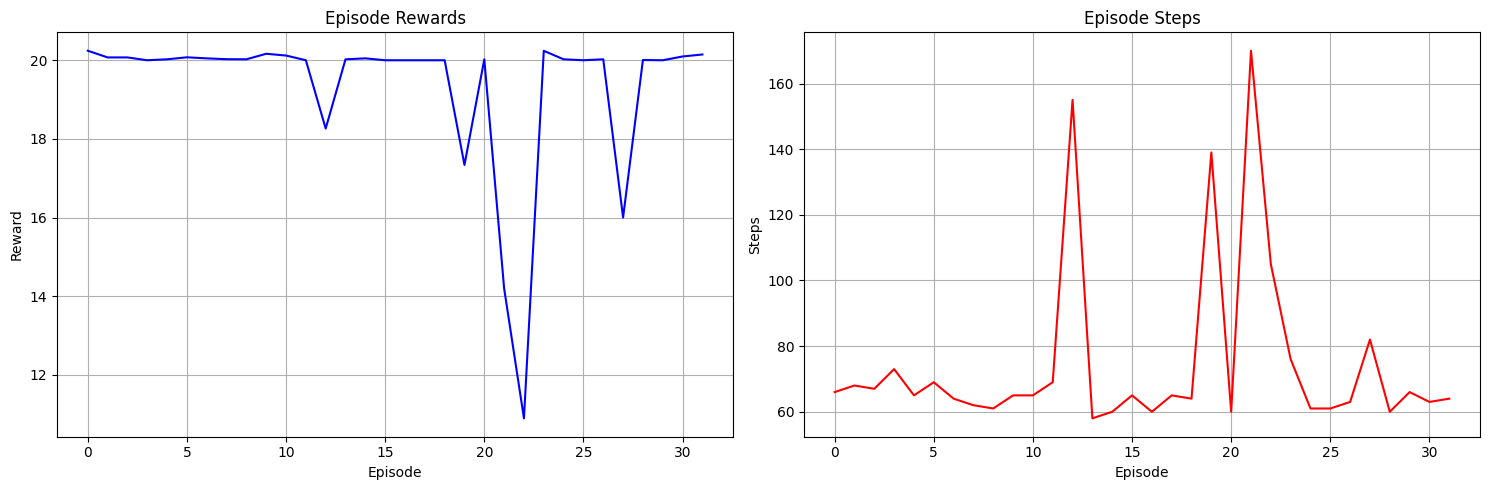

In [33]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot rewards
ax1.plot(rewards, 'b-')
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.grid(True)

# Plot steps
ax2.plot(steps, 'r-')
ax2.set_title('Episode Steps')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [34]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from sklearn.cluster import KMeans

def plot_tsne_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=2)
    transformed = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(transformed[:,0], transformed[:,1], c=labels, cmap='tab20')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    return plt.gcf()

# Assuming we have role embeddings stored over time
# This would need to be modified based on how/where embeddings are actually stored
def create_embedding_animation(embedding_sequence,  output_path=FOLDER+'embedding_animation.gif'):
    fig = plt.figure(figsize=(9,8))
    
    def animate(frame):
        plt.clf()
        embeddings = embedding_sequence[frame]
        # Kmeans clustering
        kmeans = KMeans(n_clusters=3, random_state=42, n_init= 10)
        labels = kmeans.fit_predict(embeddings)
        
        
        tsne = TSNE(n_components=2, perplexity=2, random_state=42, early_exaggeration=5)
        transformed = tsne.fit_transform(embeddings)
        
        max_x = np.abs(transformed[:, 0]).max()
        max_y = np.abs(transformed[:, 1]).max()
        
        if max_x > 60:
            transformed[:, 0] = transformed[:, 0]/max_x * 60
        
        if max_y > 60:
            transformed[:, 1] = transformed[:, 1]/max_y * 60
            
        plt.gca().set_facecolor('white')
        plt.gcf().set_facecolor('white')
        scatter_plots = []
        for i in range(3):
            mask = labels == i
            scatter = plt.scatter(transformed[mask,0], transformed[mask,1], c=labels[mask], cmap='Set1', vmin=0, vmax=2, label=f'Cluster {i+1}', s=150)
            scatter_plots.append(scatter)
        plt.legend(bbox_to_anchor=(0.5, 1.20), loc='upper center', fontsize=24, ncol=3, frameon=False)
        for i in range(len(transformed)):
            # Add small offset to annotation position to avoid overlap with points
            plt.annotate(f'{i}', (transformed[i,0] + 2, transformed[i,1] + 2), fontsize=24)
        plt.title(f'Role Embeddings at Step {frame + 1}', fontsize=24)
        plt.xlabel('TSNE-1', fontsize=24)
        plt.ylabel('TSNE-2', fontsize=24)
        
        plt.xlim(-75, 75)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylim(-75, 75)
        
    anim = FuncAnimation(fig, animate, frames=len(embedding_sequence), interval=1)
    writer = PillowWriter(fps=1)
    anim.save(output_path, writer=writer)
    plt.close()

# Note: You'll need to collect embedding_sequence and label_sequence 
# from your model's training process before using these functions
for j,embeds in enumerate(role_embeddings):
    # Create a list of labels the same length as embeds, filled with zeros
    create_embedding_animation(embeds,  output_path=FOLDER+'embedding_animation_episode{}.gif'.format(j))
    # for k,embed in enumerate(embeds):
        
    #     plot_tsne_embeddings(embeddings=embed, labels='green',title='embeds_ep{}_step{}'.format(j,k))


In [35]:
def plot_trajectory(positions, embedding_sequence, output_path=FOLDER+'embedding_animation.gif'):
    fig = plt.figure(figsize=(10,8))
    def animate(frame):
        plt.clf()
        embeddings = embedding_sequence[frame]
        # Kmeans clustering
        kmeans = KMeans(n_clusters=3, random_state=42, n_init= 10)
        labels = kmeans.fit_predict(embeddings)
        
        poses = positions[frame]
            
        plt.gca().set_facecolor('white')
        plt.gcf().set_facecolor('white')
        for i in range(3):
            mask = labels == i
            plt.scatter(poses[mask,0], poses[mask,1], c=labels[mask], cmap='Set1', vmin=0, vmax=2, label=f'Cluster {i+1}')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper right')
        for i in range(len(poses)):
            # Add small offset to annotation position to avoid overlap with points
            plt.annotate(f'{i}', (poses[i,0] + 2, poses[i,1] + 2))
        plt.title(f'Role Embeddings at Step {frame + 1}')
        plt.xlabel('TSNE-1')
        plt.ylabel('TSNE-2')
        
        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        
    anim = FuncAnimation(fig, animate, frames=len(embedding_sequence), interval=1)
    writer = PillowWriter(fps=1)
    anim.save(output_path, writer=writer)
    plt.close()


# from your model's training process before using these functions
for j,(embeds, position) in enumerate(zip(role_embeddings, positions)):
    # Create a list of labels the same length as embeds, filled with zeros
    plot_trajectory(position[0], embeds,  output_path=FOLDER+'trajectory_animation_episode{}.gif'.format(j))

In [36]:

def plot_state_occupancy(env, positions, embeddings):
    
    for j in range(len(positions.shape)):
        
        positions_role = {
            0: [],
            1: [],
            2: []
        }
        for step in range(positions[j][0].shape[0]):
            kmeans = KMeans(n_clusters=3, random_state=42, n_init= 10)
            labels = kmeans.fit_predict(embeddings[j][step])
            for cnum in range(3):
                positions_role[cnum].append(positions[j][0][step][labels==cnum])
            
        # Create a figure with 3 subplots for each role
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
        fig.suptitle(f'State Occupancy Distribution by Role')
        
        # Plot heatmap for each role
        for role in range(3):
            
            role_positions = np.concatenate(positions_role[role])
            role_positions = role_positions[role_positions[:,2]>0]
            print(role_positions)
            if len(role_positions) > 0:
                # Create 2D histogram
                
                heatmap, xedges, yedges = np.histogram2d(
                    role_positions[:, 1], 
                    role_positions[:, 0],
                    bins=10,
                    # range=[[env.map_x/2 - env.max_distance_x, env.map_x/2 + env.max_distance_x ],
                    #        [env.map_y/2 - env.max_distance_y, env.map_y/2 + env.max_distance_y]] # Assuming map size is 32x32
                )
                
                # Plot heatmap
                heatmap = heatmap/(role_positions.shape[0]*role_positions.shape[1])
                im = axes[role].imshow(heatmap.T, origin='lower', 
                                        # extent=[env.map_x/2 - env.max_distance_x, env.map_x/2 + env.max_distance_x,
                                        #          env.map_y/2 - env.max_distance_y, env.map_y/2 + env.max_distance_y], # A,
                                        cmap='viridis')
                axes[role].set_title(f'Role {role}')
                axes[role].set_xlabel('Y Position')
                axes[role].set_ylabel('X Position')
                
                # Add colorbar
                plt.colorbar(im, ax=axes[role])
          
        plt.tight_layout()
        plt.show()
        plt.savefig(FOLDER + f'state_occupancy_{j}.png')    
            

In [37]:
env, agent = init_env_agent()
print(len(positions[0][0]))
plot_state_occupancy(env, positions, role_embeddings)

------add last action------
hyper_layers_num=2
hyper_layers_num=2
66


AttributeError: 'list' object has no attribute 'shape'